In [1]:
import matplotlib.pyplot as plt

import configs as cf
from preprocess import *
from network import *
from train_tts import *
from text_to_speech import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Set Dataset
full_ds = get_single_speaker_dataset(
    cf.SPEAKER, cf.WAV_PATH, cf.SCRIPT_FILE_NAME,
    cf.SR, cf.N_MELS, cf.N_FFT, cf.HOP_LENGTH, cf.WIN_LENGTH
)

full_dl = get_dl_by_ds(full_ds, cf.BATCH_SIZE, cf.DL_NUM_WORKERS, shuffle=True)

Loading ['여1_소설1', '여1_자기계발2', '여1_동화1', '여1_자기계발1'] ...
소설1 Done!
자기계발2 Done!
동화1 Done!
자기계발1 Done!


In [4]:
# MODEL_FILE_PATH = './model/single_speaker_tts_best.pt'

# model = torch.load(MODEL_FILE_PATH).to(device)

In [5]:
model = Transformer(
    len(cf.ALL_SYMBOLS), cf.N_MELS, cf.N_LAYERS, cf.HIDDEN_DIM,
    cf.N_HEADS, cf.PF_DIM, cf.TEXT_SEQ_LEN, cf.SPEECH_SEQ_LEN,
    cf.PAD_IDX, cf.DROPOUT_RATIO, device
).to(device)
model.eval()

Transformer(
  (encoder): Encoder(
    (tok_emb): Embedding(80, 256)
    (encoder_prenet): EncoderPrenet(
      (conv_layers): ModuleList(
        (0): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
        (2): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
      )
      (batch_norm_layers): ModuleList(
        (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (dropout): Dropout(p=0.2, inplace=False)
      (projection): Linear(in_features=256, out_features=256, bias=True)
    )
    (pos_emb): Embedding(200, 256)
    (encd_stk): ModuleList(
      (0): EncoderLayer(
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_featur

In [6]:
batch = iter(full_dl).next()
tensor_dict_to_device(batch, device)

In [7]:
mel_outputs, stop_prob, enc_attention, dec_attention, attention, enc_energy, dec_energy, enc_dec_energy = model(batch['text_tokens'], batch['mel'])

query: torch.Size([8, 8, 84, 32])
tensor([[ 0.3017, -0.8280,  0.0665,  ...,  1.4892, -0.1668,  0.0344],
        [-0.4731, -0.3601,  0.2659,  ...,  0.3942,  0.0432, -1.2026],
        [-0.2049, -2.0851,  0.1212,  ...,  0.8929, -0.0549, -0.5472],
        ...,
        [-0.9467, -1.2536,  0.7948,  ..., -0.4123, -0.4358,  0.3003],
        [-1.3129, -0.5551,  0.1576,  ...,  0.1153,  0.7270, -0.6385],
        [-0.7556, -0.9927, -0.1831,  ...,  1.1174, -0.4628,  0.6479]],
       device='cuda:0', grad_fn=<SelectBackward0>)

key: torch.Size([8, 8, 84, 32])
tensor([[-0.0053, -0.2982,  1.3848,  ..., -0.3555, -0.1288,  0.0592],
        [ 0.1992,  0.1178,  0.0900,  ..., -0.3467, -0.7215,  0.8835],
        [-0.1739,  0.8113,  1.2721,  ...,  0.4927,  0.1379,  0.5306],
        ...,
        [ 0.5855,  0.2674,  0.3513,  ..., -1.0270,  0.2393,  0.1135],
        [ 0.7776,  0.3811,  0.6607,  ..., -0.7000,  0.1009, -0.1727],
        [ 0.5325,  1.3860, -0.5290,  ..., -0.4050, -0.8973, -0.3014]],
       device=

In [8]:
# Random으로 테스트

# batch = {
#     'text_tokens': torch.randint(0, 40, (8, 64)),
#     'mel': torch.rand(8, 275, 80)
# }
# tensor_dict_to_device(batch, device)
# mel_outputs, stop_prob, enc_attention, dec_attention, attention, enc_energy, dec_energy, enc_dec_energy = model(batch['text_tokens'], batch['mel'])

In [9]:
# attention의 query, key, value가 seq에 따라 다르지 않고 모두 똑같은 현상이 있음.
# layer stack이 쌓임에 따라서 output에 가까운 attention일수록 더욱 더 똑같아짐.
# 이렇게 작동하는 가장 큰 이유는 output에서 가장 먼 attention(첫번째 encoder의 attention)의 결과가 query, key가 어떻든 관계없이 하나는 1, 나머지는 0인데 그 1의 위치마저 모두 같음.
# 모델 최초 init에서는 정상적으로 random함. 하지만 학습과정에서 이렇게 유도되는 듯 하다. 이유를 모르겠다.
# chatbot에서는 어땠는지 확인하는게 좋을듯.

In [10]:
i = 1

print(enc_energy[0][0][0][i])
print(torch.softmax(enc_energy[0][0][0][i], axis=-1))

tensor([-3.1974e-01, -7.4968e-01,  6.6578e-02,  2.3932e-01, -6.9929e-01,
        -5.0560e-01, -8.7178e-01, -3.3454e-01, -7.5168e-01, -1.1396e+00,
         1.1307e-01, -7.1924e-01,  4.1139e-01, -5.3292e-01, -1.2635e-01,
        -7.7483e-01, -6.3297e-01, -2.6462e-01, -3.2940e-01, -7.8628e-01,
        -1.6366e+00, -4.0943e-01, -8.5402e-01, -9.7093e-01, -4.9613e-01,
        -1.3460e+00, -1.5429e-01,  1.0919e-01, -3.1392e-01, -7.1912e-01,
         3.3722e-02, -3.2023e-01, -1.2909e+00, -2.9515e-01, -8.0552e-01,
        -1.0374e+00, -1.2033e-01, -8.6898e-01, -4.8677e-01, -4.5012e-01,
        -1.4455e+00, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
        -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0

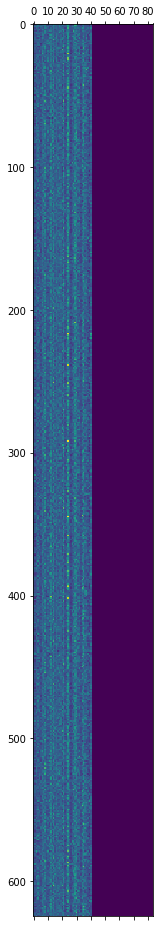

In [11]:
plt.matshow(attention[0][0][0].detach().cpu().numpy())